In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [177]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [178]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')

run id: 20241116_174053


In [179]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Nov 16 17:40:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DB:00.0 Off |                  N/A |
|  0%   28C    P8              26W / 250W |   4733MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [180]:
from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
)

from sourcerer.likelihood_estimator import train_lml_source
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
)
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)
from sourcerer.wasserstein_estimator import train_source

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [181]:
def get_simulator(cfg):
    if cfg.simulator.self == "two_moons":
        return TwoMoonsSimulator()
    elif cfg.simulator.self == "inverse_kinematics":
        return InverseKinematicsSimulator()
    elif cfg.simulator.self == "slcp":
        return SLCPSimulator()
    elif cfg.simulator.self == "sir":
        return SIRSimulator()
    elif cfg.simulator.self == "lotka_volterra":
        return LotkaVolterraSimulator()

In [182]:
# simulator_str = "inverse_kinematics"
# simulator_str = "two_moons"
simulator_str = "slcp"

In [183]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    f"base.tag=debug_{run_id}",
    f"base.folder=sequential_slcp",# _{run_id}",
    f"simulator={simulator_str}",
    "surrogate.self=train_surrogate",
    "+surrogate.num_training_samples=15000",

"surrogate.flow_length=8",
"surrogate.hidden_layer_dim=50",

"+surrogate.nb_epochs=5000", # do we need to increase it to make sure the surrogates converge at each iteration?
"+surrogate.surrogate_lr=0.0001",
"+surrogate.surrogate_weight_decay=0.00005",

"+surrogate.early_stopping_patience=50"
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

base:
  tag: debug_20241116_174053
  folder: sequential_slcp
  base_path: ../results_sourcerer
  seed: null
simulator:
  self: slcp
  box_domain_lower: -5.0
  box_domain_upper: 5.0
surrogate:
  self: train_surrogate
  flow_length: 8
  hidden_layer_dim: 50
  num_training_samples: 15000
  nb_epochs: 5000
  surrogate_lr: 0.0001
  surrogate_weight_decay: 5.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein
  num_obs: 10000
  num_eval_obs: 10000
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 0
  linear_decay_steps: 500
  lambda_steps: 3000
  fin_lambda: 0.35
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 500



In [184]:
# save the above config file in ../results_sourcerer/sequential directory
save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

# set seed
if cfg.base.seed is None:
    random_random_seed = 20367# np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 20367


In [185]:
# Define Simulator and reference domain. Train a surrogate/load an existing surrogate if necessary.
simulator = get_simulator(cfg)
simulator = simulator.to(device)

## this is the initial distribution to sample theta from to train the surrogate
box_domain = TemperedUniform(
    cfg.simulator.box_domain_lower,
    cfg.simulator.box_domain_upper,
    simulator.xdim,
    device=device,
)

# notation here: θ (which is x here), and x (which is x here) 
print(f"θ/parameter dimension: {simulator.xdim}")
print(f"x/observation dimension: {simulator.ydim}")

θ/parameter dimension: 5
x/observation dimension: 8


In [186]:
surrogate = RealNVPs(
    flow_length=cfg.surrogate.flow_length, # 1 RealNVP layer
    data_dim=simulator.ydim,    # this is x ~ p(x|theta)
    context_dim=simulator.xdim, # this is theta! okay so context dim is theta's dimension
    hidden_layer_dim=cfg.surrogate.hidden_layer_dim # 5,
)
surrogate = surrogate.to(device)

surro_optimizer = torch.optim.Adam(
    surrogate.parameters(),
    lr=cfg.surrogate.surrogate_lr, # 0.0001
    weight_decay=cfg.surrogate.surrogate_weight_decay, # 0.00005
)

assert cfg.surrogate.self == "train_surrogate"

In [187]:
cfg.source.fin_lambda

0.35

In [188]:
# add this to the config later, create a folder called `sequential`
TOTAL_SIMULATION_BUDGET = 15000 #cfg.surrogate.num_training_samples # 15000 -> variable
NUMBER_OF_ITERATIONS = 5
MINIMUM_SAMPLES_PER_ITERATION = TOTAL_SIMULATION_BUDGET // NUMBER_OF_ITERATIONS
# NUMBER_OF_ITERATIONS = TOTAL_SIMULATION_BUDGET // MINIMUM_SAMPLES_PER_ITERATION
print(f"{NUMBER_OF_ITERATIONS=}")
print(f"{MINIMUM_SAMPLES_PER_ITERATION=}")

# high simulation budget vs. low simulation budget (2000)
# low simulation budget -- iterative method

NUMBER_OF_ITERATIONS=5
MINIMUM_SAMPLES_PER_ITERATION=3000


In [189]:
BUDGET_SCHEDULER = np.ones(NUMBER_OF_ITERATIONS) / NUMBER_OF_ITERATIONS
# BUDGET_SCHEDULER = np.array([0.4, 0.2, 0.15, 0.15, 0.1])
BUDGET_PER_ITERATION = (BUDGET_SCHEDULER*TOTAL_SIMULATION_BUDGET).astype(int)
BUDGET_PER_ITERATION

array([3000, 3000, 3000, 3000, 3000])

In [190]:
# 0.5/3

In [191]:
## used for evaluation of surrogate and estimated source later
gt_source = simulator.sample_prior(cfg.source.num_obs)          # 10k thetas from true source distribution
gt_source_two = simulator.sample_prior(cfg.source.num_eval_obs) # 10k thetas for validation

with torch.no_grad():
    # simulator generated observations/pfs from the above 2 sets of 10k thetas
    gt_simulator = simulator.sample(context=gt_source)
    gt_simulator_two = simulator.sample(context=gt_source_two)

print("Sliced wassertein distance on groundtruth y:")
excepted_distance = sliced_wasserstein_distance(
    gt_simulator[: cfg.source.num_eval_obs],  # from theta1
    gt_simulator_two,                         # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"expected/baseline swd: {excepted_distance}, log of that: {np.log(excepted_distance)}")

Sliced wassertein distance on groundtruth y:
expected/baseline swd: 0.17703132331371307, log of that: -1.7314285941911898


In [192]:
## define source model
if cfg.source_model.self == "sampler":
    # easier to scale, used in the paper
    # note that Sampler() model does not have log-density evaluation
    print("init sampler source")
    source = Sampler(
        xdim=simulator.xdim,
        input_noise_dim=simulator.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=simulator.xdim,
        context_dim=0,  # here we are not using it as a conditioning mechanism!
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

# This is the scheduled values of lambda - first we linearly decay from lambda=1.0 (only entropy) until a minimum value of lambda. Then we stay at that value of lambda for more iterations.
schedule = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps),
    ]
)

schedule

init sampler source


tensor([1.0000, 0.9987, 0.9974,  ..., 0.3500, 0.3500, 0.3500])

In [193]:
# cfg.source.num_eval_obs, cfg.source.num_obs

ITERATION: 1/5 training with 3000 samples
Epoch: 0, Train Loss: 11738.32001953125, Val Loss: 2312.086181640625
Validation loss did not improve for 50 epochs, stopping training after 484 epochs.


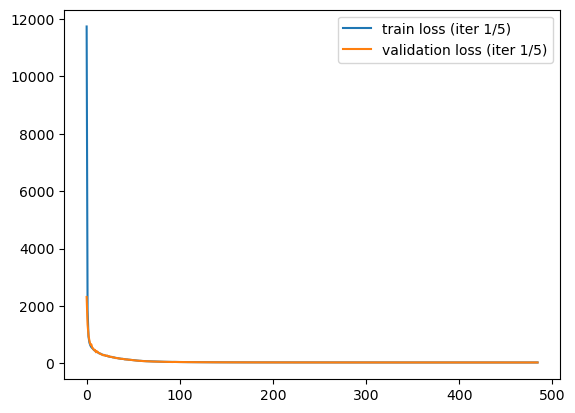

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.79775
Surrogate vs Simulator y-space SWD AUC after iteration 0: 3.521630048751831
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.499717652797699
Epoch x Chunk: 500, Weighted Loss: 1.5489729074326055, Entropy loss: 0.7913107744754901, Wasser loss: 1.9569449424743652
Epoch x Chunk: 1000, Weighted Loss: 1.3896313789811459, Entropy loss: 0.7556298598404494, Wasser loss: 1.7310168743133545
Epoch x Chunk: 1500, Weighted Loss: 1.49062348545174, Entropy loss: 0.8511914994403034, Wasser loss: 1.8349330425262451
Epoch x Chunk: 2000, Weighted Loss: 1.4947990726704707, Entropy loss: 0.9528516044067219, Wasser loss: 1.7866170406341553
Training loss did not improve. Stopped training after 2126 epochs x chunks.
y c2st AUC on simulator: 0.62995
y c2st AUC on surrogate: 0.5580999999999999
Source c2st AUC: 0.8474999999999999
Ground truth source entropy estimate: 9.165601713214292
Estimated s

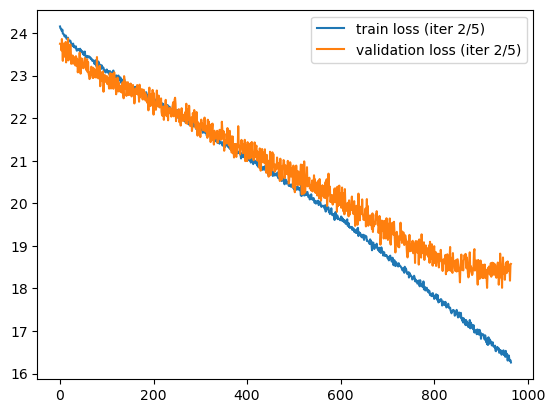

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.64375
Surrogate vs Simulator y-space SWD AUC after iteration 1: 0.7295862436294556
Epoch x Chunk: 0, Weighted Loss: 0.8429082753684147, Entropy loss: 0.8429082753684147, Wasser loss: 1.3988690376281738
Epoch x Chunk: 500, Weighted Loss: 0.060192150261312305, Entropy loss: 1.2389107823933143, Wasser loss: -0.5745025277137756
Epoch x Chunk: 1000, Weighted Loss: 0.010193315268998582, Entropy loss: 1.6171148187323245, Wasser loss: -0.8550721406936646
Epoch x Chunk: 1500, Weighted Loss: -0.06886873052088316, Entropy loss: 1.5561520351717393, Wasser loss: -0.9438799619674683
Training loss did not improve. Stopped training after 1876 epochs x chunks.
y c2st AUC on simulator: 0.56395
y c2st AUC on surrogate: 0.55535
Source c2st AUC: 0.7932500000000001
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.698053441357898
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/5 

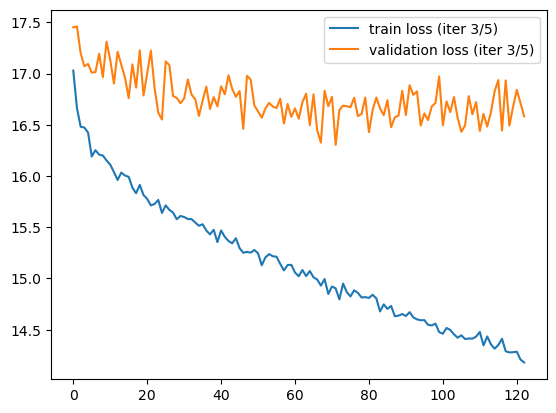

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.6165499999999999
Surrogate vs Simulator y-space SWD AUC after iteration 2: 0.7222270965576172
Epoch x Chunk: 0, Weighted Loss: 1.584736331217866, Entropy loss: 1.584736331217866, Wasser loss: -0.5937482118606567
Epoch x Chunk: 500, Weighted Loss: -0.03153853823108377, Entropy loss: 1.184476316012737, Wasser loss: -0.6863157749176025
Epoch x Chunk: 1000, Weighted Loss: -0.09752152846211248, Entropy loss: 1.5337399764937993, Wasser loss: -0.9758931398391724
Epoch x Chunk: 1500, Weighted Loss: -0.15044105329019763, Entropy loss: 1.5681021742298027, Wasser loss: -1.0758105516433716
Epoch x Chunk: 2000, Weighted Loss: -0.21641625904584771, Entropy loss: 1.4353668382529774, Wasser loss: -1.1058379411697388
Training loss did not improve. Stopped training after 2064 epochs x chunks.
y c2st AUC on simulator: 0.5580999999999999
y c2st AUC on surrogate: 0.5609
Source c2st AUC: 0.7832000000000001
Ground truth source entropy estimate: 9.1

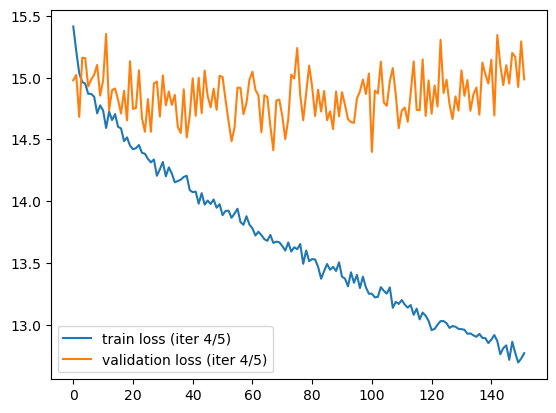

Surrogate vs Simulator y-space C2ST AUC after iteration 3: 0.5923
Surrogate vs Simulator y-space SWD AUC after iteration 3: 0.9163447022438049
Epoch x Chunk: 0, Weighted Loss: 1.5277881154869943, Entropy loss: 1.5277881154869943, Wasser loss: -0.6979340314865112
Epoch x Chunk: 500, Weighted Loss: -0.1499421960142655, Entropy loss: 1.0974757159951585, Wasser loss: -0.8216288089752197
Epoch x Chunk: 1000, Weighted Loss: -0.15477644021331488, Entropy loss: 1.3207226758177617, Wasser loss: -0.9492759704589844
Epoch x Chunk: 1500, Weighted Loss: -0.16624297566205426, Entropy loss: 1.4753697321026573, Wasser loss: -1.0501883029937744
Training loss did not improve. Stopped training after 1757 epochs x chunks.
y c2st AUC on simulator: 0.5586
y c2st AUC on surrogate: 0.572
Source c2st AUC: 0.7867500000000001
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.716659859226741
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 5/5 trai

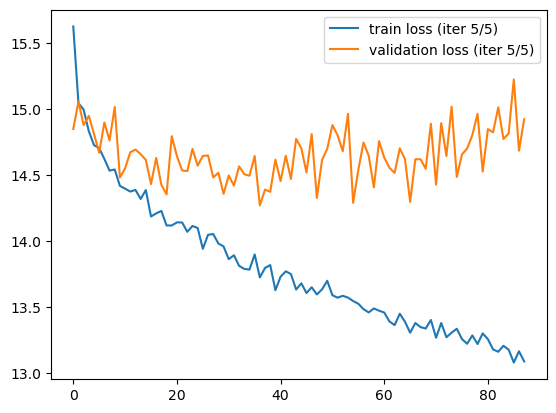

Surrogate vs Simulator y-space C2ST AUC after iteration 4: 0.5784999999999999
Surrogate vs Simulator y-space SWD AUC after iteration 4: 0.6609715223312378
Epoch x Chunk: 0, Weighted Loss: 1.4572284045318584, Entropy loss: 1.4572284045318584, Wasser loss: -1.0896780490875244
Epoch x Chunk: 500, Weighted Loss: -0.11270461418650113, Entropy loss: 1.1248216383931586, Wasser loss: -0.7790648937225342
Epoch x Chunk: 1000, Weighted Loss: -0.23846217260670244, Entropy loss: 1.5203879176526174, Wasser loss: -1.1855353116989136
Epoch x Chunk: 1500, Weighted Loss: -0.1957158310476339, Entropy loss: 1.6387042644645087, Wasser loss: -1.1834805011749268
Epoch x Chunk: 2000, Weighted Loss: -0.3171907468179265, Entropy loss: 1.427679312263602, Wasser loss: -1.256736159324646
Training loss did not improve. Stopped training after 2365 epochs x chunks.
y c2st AUC on simulator: 0.5454
y c2st AUC on surrogate: 0.5584
Source c2st AUC: 0.7825
Ground truth source entropy estimate: 9.165601713214292
Estimated 

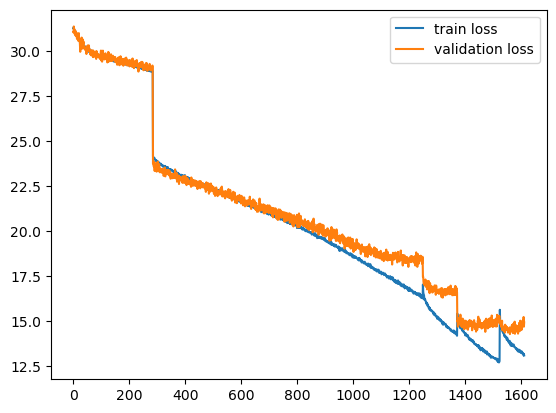

In [194]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)



start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

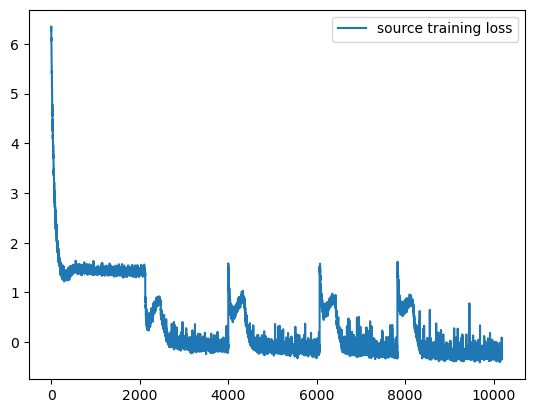

In [195]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

## 15k with 3 iterations (5k samples per iteration)

ITERATION: 1/3 training with 5000 samples
Epoch: 0, Train Loss: 13544.552551269531, Val Loss: 2428.758056640625
Epoch: 500, Train Loss: 27.390628695487976, Val Loss: 28.029046058654785
Epoch: 1000, Train Loss: 21.488133192062378, Val Loss: 23.935046672821045
Validation loss did not improve for 50 epochs, stopping training after 1051 epochs.


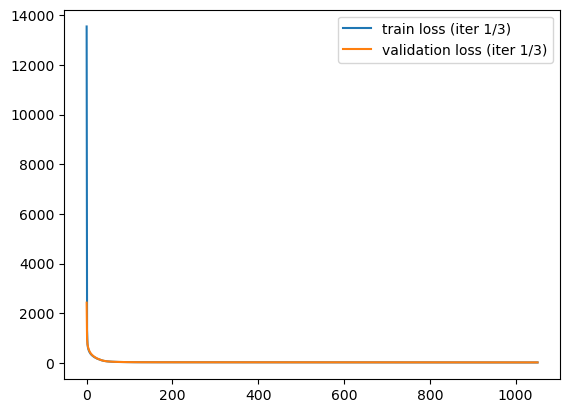

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.61785
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.4435233473777771
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.9210498332977295
Epoch x Chunk: 500, Weighted Loss: -0.1549725259878597, Entropy loss: 1.5157385568976265, Wasser loss: -1.0545861721038818
Epoch x Chunk: 1000, Weighted Loss: -0.2840817386248362, Entropy loss: 1.5718375728163272, Wasser loss: -1.2834229469299316
Epoch x Chunk: 1500, Weighted Loss: -0.2745041295210251, Entropy loss: 1.5393676212975889, Wasser loss: -1.2512043714523315
Epoch x Chunk: 2000, Weighted Loss: -0.30906982442786035, Entropy loss: 1.5751297054979938, Wasser loss: -1.3236387968063354
Training loss did not improve. Stopped training after 2418 epochs x chunks.
y c2st AUC on simulator: 0.5475999999999999
y c2st AUC on surrogate: 0.53925
Source c2st AUC: 0.75575
Ground truth source entropy estimate: 9.165601713214292
Estimated

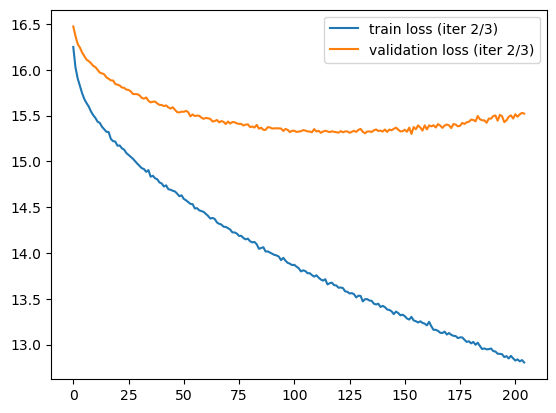

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.5572
Surrogate vs Simulator y-space SWD AUC after iteration 1: 0.4793086647987366
Epoch x Chunk: 0, Weighted Loss: 1.3484111879301404, Entropy loss: 1.3484111879301404, Wasser loss: -1.0063412189483643
Epoch x Chunk: 500, Weighted Loss: -0.3061216920258373, Entropy loss: 1.2002235430682395, Wasser loss: -1.1172306537628174
Epoch x Chunk: 1000, Weighted Loss: -0.3961100017912166, Entropy loss: 1.6232604814451799, Wasser loss: -1.4834634065628052
Epoch x Chunk: 1500, Weighted Loss: -0.23846240592482593, Entropy loss: 1.6219074164305853, Wasser loss: -1.2402000427246094
Epoch x Chunk: 2000, Weighted Loss: -0.4567466452119153, Entropy loss: 1.5826533580285593, Wasser loss: -1.5548851490020752
Epoch x Chunk: 2500, Weighted Loss: -0.351074811699736, Entropy loss: 1.5624547359261642, Wasser loss: -1.3814369440078735
Training loss did not improve. Stopped training after 2520 epochs x chunks.
y c2st AUC on simulator: 0.53885
y c2st AU

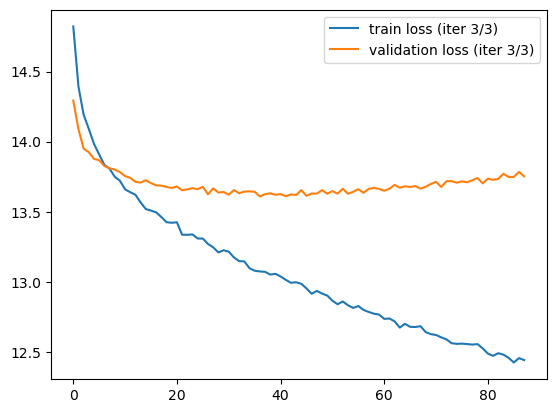

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.53725
Surrogate vs Simulator y-space SWD AUC after iteration 2: 0.4329705238342285
Epoch x Chunk: 0, Weighted Loss: 1.4165476503928494, Entropy loss: 1.4165476503928494, Wasser loss: -1.1298860311508179
Epoch x Chunk: 500, Weighted Loss: -0.26064471557764185, Entropy loss: 1.2550671497416586, Wasser loss: -1.0767972469329834
Epoch x Chunk: 1000, Weighted Loss: -0.3363645213142593, Entropy loss: 1.5279880462327808, Wasser loss: -1.3402466773986816
Training loss did not improve. Stopped training after 1369 epochs x chunks.
y c2st AUC on simulator: 0.5478999999999999
y c2st AUC on surrogate: 0.54685
Source c2st AUC: 0.7719
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.743054274736496
--__----__----__----__----__----__----__----__----__----__--


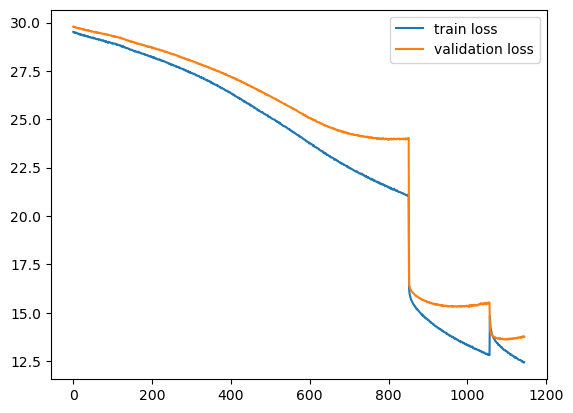

In [172]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)



start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

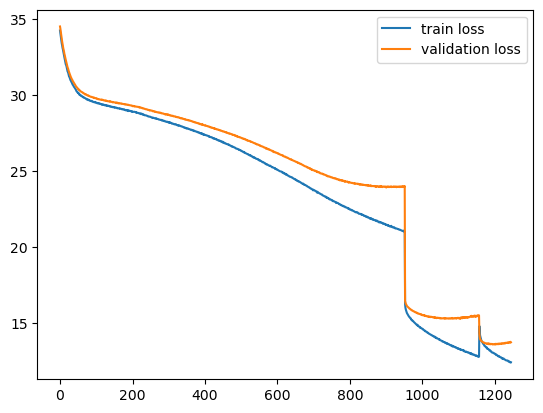

In [175]:
start_idx=100
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

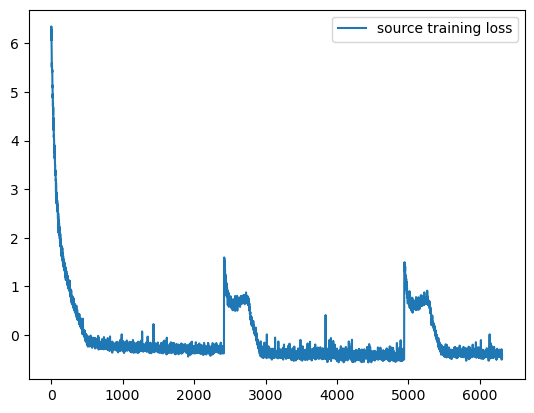

In [176]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

## 4000 per iteration

ITERATION: 1/3 training with 4000 samples
Epoch: 0, Train Loss: 37844.690354567305, Val Loss: 1711.0252380371094
Validation loss did not improve for 50 epochs, stopping training after 490 epochs.


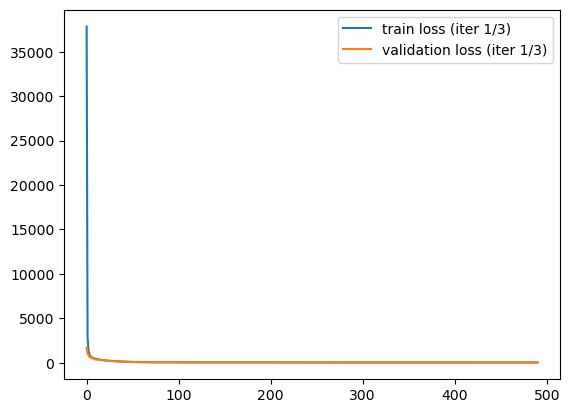

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.7873499999999999
Surrogate vs Simulator y-space SWD AUC after iteration 0: 2.6980934143066406
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.3012872636318207
Epoch x Chunk: 500, Weighted Loss: 1.3918083475238767, Entropy loss: 0.8932051260695557, Wasser loss: 1.6602871417999268
Epoch x Chunk: 1000, Weighted Loss: 1.267291001873341, Entropy loss: 1.1301607721705986, Wasser loss: 1.3411303758621216
Epoch x Chunk: 1500, Weighted Loss: 1.401645312027358, Entropy loss: 1.3527438113595354, Wasser loss: 1.4279769659042358
Epoch x Chunk: 2000, Weighted Loss: 1.2467494264227228, Entropy loss: 1.372963626430118, Wasser loss: 1.1787879467010498
Training loss did not improve. Stopped training after 2207 epochs x chunks.
y c2st AUC on simulator: 0.5820500000000001
y c2st AUC on surrogate: 0.5188
Source c2st AUC: 0.7783
Ground truth source entropy estimate: 9.165601713214292
Estimated so

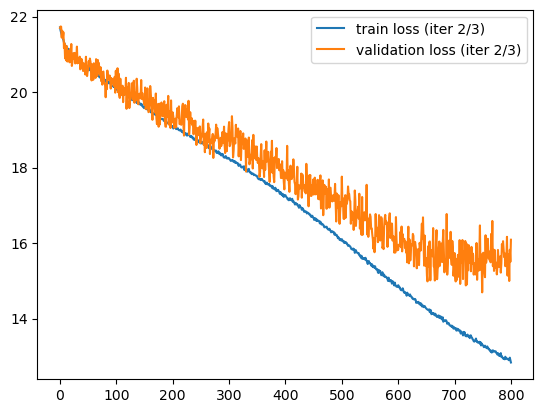

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.6003000000000001
Surrogate vs Simulator y-space SWD AUC after iteration 1: 1.4040693044662476
Epoch x Chunk: 0, Weighted Loss: 1.2733801717772417, Entropy loss: 1.2733801717772417, Wasser loss: 0.42402365803718567
Epoch x Chunk: 500, Weighted Loss: -0.11656804349231181, Entropy loss: 1.1031179540402354, Wasser loss: -0.7733221054077148
Epoch x Chunk: 1000, Weighted Loss: -0.19430277728793877, Entropy loss: 1.4523770947589307, Wasser loss: -1.0809766054153442
Training loss did not improve. Stopped training after 1465 epochs x chunks.
y c2st AUC on simulator: 0.562
y c2st AUC on surrogate: 0.55765
Source c2st AUC: 0.77745
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.7436644038944
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/3 training with 4000 samples
Epoch: 0, Train Loss: 15.937026170583872, Val Loss: 15.714187383651733
Validation loss did not improv

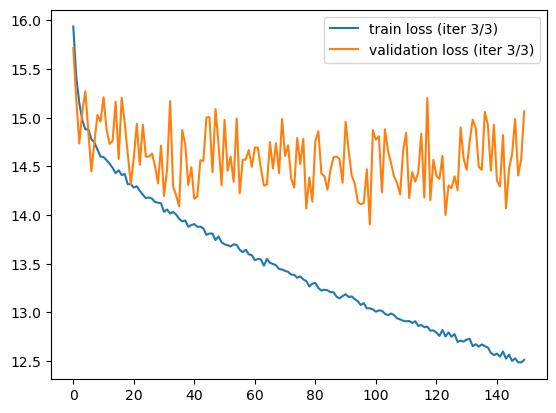

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.57745
Surrogate vs Simulator y-space SWD AUC after iteration 2: 0.5260411500930786
Epoch x Chunk: 0, Weighted Loss: 1.344251343611119, Entropy loss: 1.344251343611119, Wasser loss: -0.982970118522644
Epoch x Chunk: 500, Weighted Loss: -0.030650342674415243, Entropy loss: 1.2702356419394496, Wasser loss: -0.7311274409294128
Epoch x Chunk: 1000, Weighted Loss: -0.24118553782183094, Entropy loss: 1.4717967651685049, Wasser loss: -1.1635606288909912
Training loss did not improve. Stopped training after 1217 epochs x chunks.
y c2st AUC on simulator: 0.5633
y c2st AUC on surrogate: 0.5659000000000001
Source c2st AUC: 0.79675
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.852573294782351
--__----__----__----__----__----__----__----__----__----__--


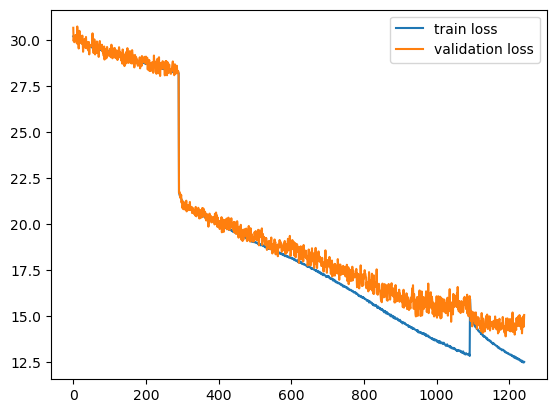

In [153]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)



start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

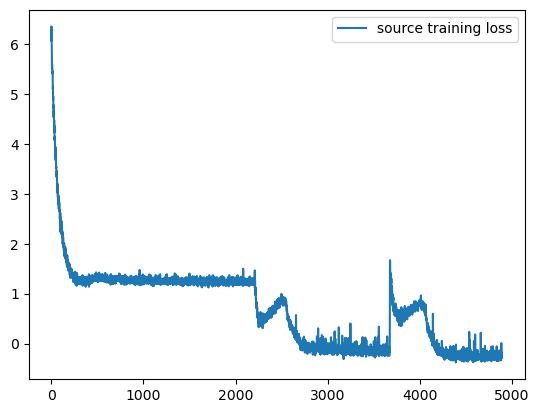

In [154]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

ITERATION: 1/3 training with 3000 samples
Epoch: 0, Train Loss: 11738.32001953125, Val Loss: 2312.086181640625
Validation loss did not improve for 50 epochs, stopping training after 484 epochs.


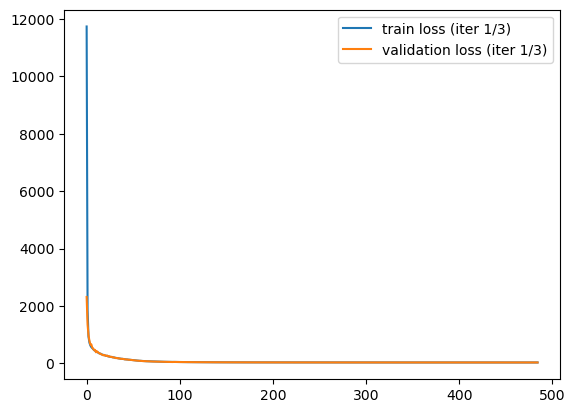

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.79775
Surrogate vs Simulator y-space SWD AUC after iteration 0: 3.521630048751831
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.499717652797699
Epoch x Chunk: 500, Weighted Loss: 1.5489729074326055, Entropy loss: 0.7913107744754901, Wasser loss: 1.9569449424743652
Epoch x Chunk: 1000, Weighted Loss: 1.3896313789811459, Entropy loss: 0.7556298598404494, Wasser loss: 1.7310168743133545
Epoch x Chunk: 1500, Weighted Loss: 1.49062348545174, Entropy loss: 0.8511914994403034, Wasser loss: 1.8349330425262451
Epoch x Chunk: 2000, Weighted Loss: 1.4947990726704707, Entropy loss: 0.9528516044067219, Wasser loss: 1.7866170406341553
Training loss did not improve. Stopped training after 2126 epochs x chunks.
y c2st AUC on simulator: 0.62995
y c2st AUC on surrogate: 0.5580999999999999
Source c2st AUC: 0.8474999999999999
Ground truth source entropy estimate: 9.165601713214292
Estimated s

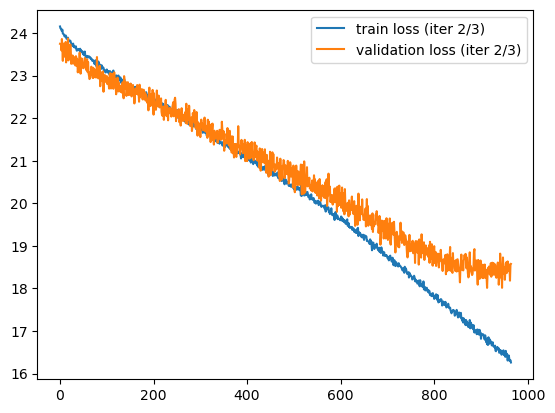

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.64375
Surrogate vs Simulator y-space SWD AUC after iteration 1: 0.7295862436294556
Epoch x Chunk: 0, Weighted Loss: 0.8429082753684147, Entropy loss: 0.8429082753684147, Wasser loss: 1.3988690376281738
Epoch x Chunk: 500, Weighted Loss: 0.060192150261312305, Entropy loss: 1.2389107823933143, Wasser loss: -0.5745025277137756
Epoch x Chunk: 1000, Weighted Loss: 0.010193315268998582, Entropy loss: 1.6171148187323245, Wasser loss: -0.8550721406936646
Epoch x Chunk: 1500, Weighted Loss: -0.06886873052088316, Entropy loss: 1.5561520351717393, Wasser loss: -0.9438799619674683
Training loss did not improve. Stopped training after 1876 epochs x chunks.
y c2st AUC on simulator: 0.56395
y c2st AUC on surrogate: 0.55535
Source c2st AUC: 0.7932500000000001
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.698053441357898
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/3 

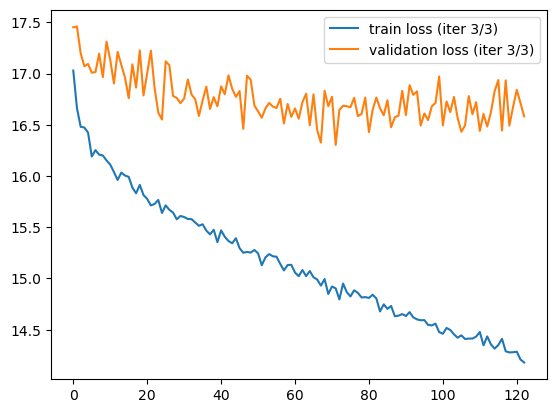

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.6165499999999999
Surrogate vs Simulator y-space SWD AUC after iteration 2: 0.7222270965576172
Epoch x Chunk: 0, Weighted Loss: 1.584736331217866, Entropy loss: 1.584736331217866, Wasser loss: -0.5937482118606567
Epoch x Chunk: 500, Weighted Loss: -0.03153853823108377, Entropy loss: 1.184476316012737, Wasser loss: -0.6863157749176025
Epoch x Chunk: 1000, Weighted Loss: -0.09752152846211248, Entropy loss: 1.5337399764937993, Wasser loss: -0.9758931398391724
Epoch x Chunk: 1500, Weighted Loss: -0.15044105329019763, Entropy loss: 1.5681021742298027, Wasser loss: -1.0758105516433716
Epoch x Chunk: 2000, Weighted Loss: -0.21641625904584771, Entropy loss: 1.4353668382529774, Wasser loss: -1.1058379411697388
Training loss did not improve. Stopped training after 2064 epochs x chunks.
y c2st AUC on simulator: 0.5580999999999999
y c2st AUC on surrogate: 0.5609
Source c2st AUC: 0.7832000000000001
Ground truth source entropy estimate: 9.1

In [134]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)



start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()




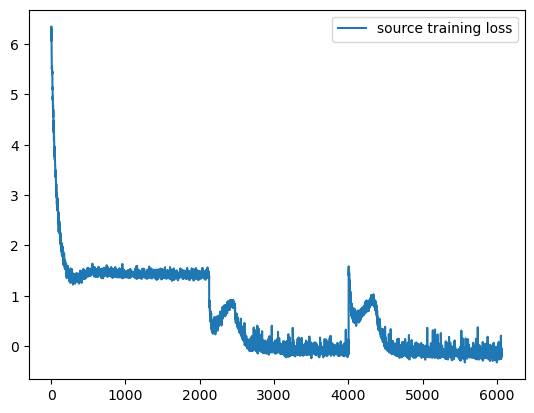

In [136]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

ITERATION: 1/3 training with 2000 samples
Epoch: 0, Train Loss: 24310.85374232701, Val Loss: 18606.252685546875
Validation loss did not improve for 50 epochs, stopping training after 444 epochs.


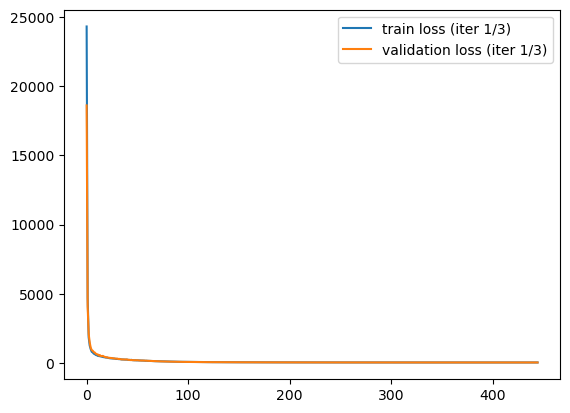

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.8083
Surrogate vs Simulator y-space SWD AUC after iteration 0: 4.0704851150512695
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.6716846227645874
Epoch x Chunk: 500, Weighted Loss: 1.5823815554795428, Entropy loss: 0.7670857612413764, Wasser loss: 2.0213871002197266
Epoch x Chunk: 1000, Weighted Loss: 1.4770480723974153, Entropy loss: 0.7161189189309676, Wasser loss: 1.8867791891098022
Epoch x Chunk: 1500, Weighted Loss: 1.6078380250061255, Entropy loss: 0.922940106193539, Wasser loss: 1.9766292572021484
Training loss did not improve. Stopped training after 1616 epochs x chunks.
y c2st AUC on simulator: 0.6465
y c2st AUC on surrogate: 0.5599999999999999
Source c2st AUC: 0.84535
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 10.462199419482243
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 2/3 training with

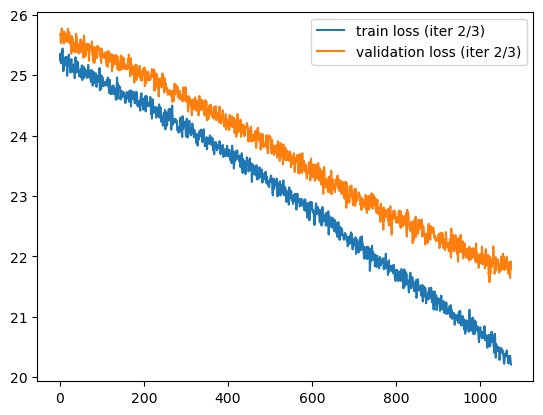

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.7355
Surrogate vs Simulator y-space SWD AUC after iteration 1: 1.0531927347183228
Epoch x Chunk: 0, Weighted Loss: 0.8874026895757412, Entropy loss: 0.8874026895757412, Wasser loss: 1.7300196886062622
Epoch x Chunk: 500, Weighted Loss: 0.20651968123749415, Entropy loss: 1.1474663300376653, Wasser loss: -0.30014389753341675
Epoch x Chunk: 1000, Weighted Loss: 0.44632189460829547, Entropy loss: 1.117793822825294, Wasser loss: 0.08476009964942932
Epoch x Chunk: 1500, Weighted Loss: 0.1410051258476896, Entropy loss: 1.1455335903180037, Wasser loss: -0.3998948335647583
Training loss did not improve. Stopped training after 1617 epochs x chunks.
y c2st AUC on simulator: 0.6178
y c2st AUC on surrogate: 0.58345
Source c2st AUC: 0.85075
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 10.237507248804308
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/3 training with 20

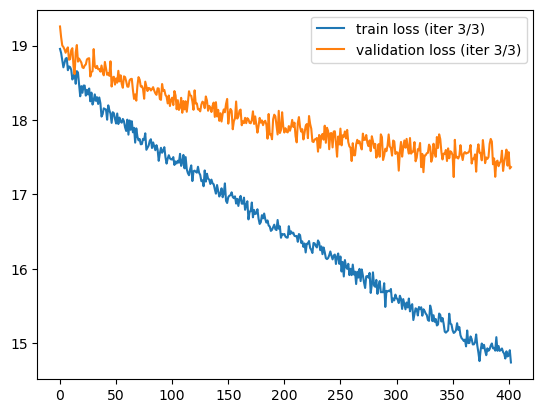

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.6683
Surrogate vs Simulator y-space SWD AUC after iteration 2: 1.5548313856124878
Epoch x Chunk: 0, Weighted Loss: 1.0607807428091762, Entropy loss: 1.0607807428091762, Wasser loss: 0.21041081845760345
Epoch x Chunk: 500, Weighted Loss: 0.19362098662440824, Entropy loss: 1.1174947834832816, Wasser loss: -0.3038495182991028
Epoch x Chunk: 1000, Weighted Loss: 0.12460906727094312, Entropy loss: 1.3448297758862156, Wasser loss: -0.5324328541755676
Training loss did not improve. Stopped training after 1432 epochs x chunks.
y c2st AUC on simulator: 0.5879000000000001
y c2st AUC on surrogate: 0.5968
Source c2st AUC: 0.8147499999999999
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.938590571629405
--__----__----__----__----__----__----__----__----__----__--


In [114]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

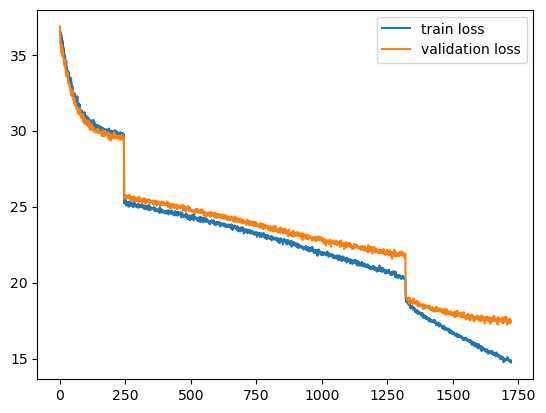

In [115]:
start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

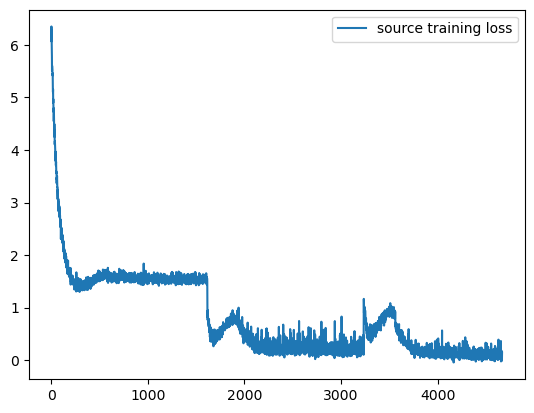

In [116]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

ITERATION: 1/5 training with 1000 samples
Epoch: 0, Train Loss: 28925.091552734375, Val Loss: 46941.21875
Epoch: 500, Train Loss: 30.066238403320312, Val Loss: 32.0841064453125


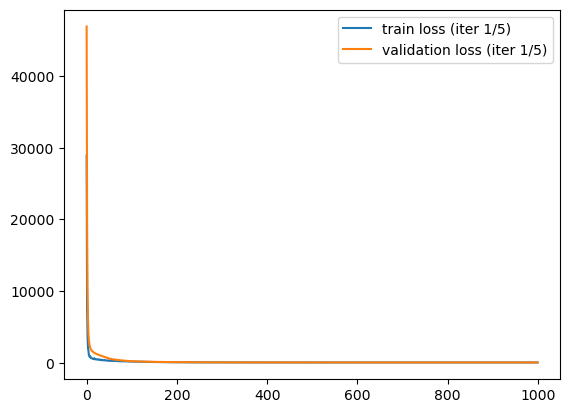

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.8012
Surrogate vs Simulator y-space SWD AUC after iteration 0: 3.0513739585876465
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.2716542184352875
Epoch x Chunk: 500, Weighted Loss: 1.4362034095374538, Entropy loss: 0.8413636524136896, Wasser loss: 1.7565017938613892
Epoch x Chunk: 1000, Weighted Loss: 1.355017363299926, Entropy loss: 1.23148749742884, Wasser loss: 1.421533465385437
Epoch x Chunk: 1500, Weighted Loss: 1.4025858451521824, Entropy loss: 1.343186381370571, Wasser loss: 1.4345701932907104
Epoch x Chunk: 2000, Weighted Loss: 1.4246898687093763, Entropy loss: 1.5023794873419485, Wasser loss: 1.382857084274292
Training loss did not improve. Stopped training after 2402 epochs x chunks.
y c2st AUC on simulator: 0.5824
y c2st AUC on surrogate: 0.5042500000000001
Source c2st AUC: 0.7546999999999999
Ground truth source entropy estimate: 9.165601713214292
Estimated sourc

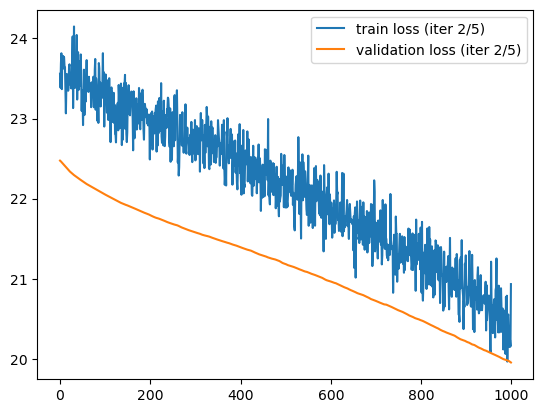

Surrogate vs Simulator y-space C2ST AUC after iteration 1: 0.75585
Surrogate vs Simulator y-space SWD AUC after iteration 1: 1.076910376548767
Epoch x Chunk: 0, Weighted Loss: 1.5791445251074672, Entropy loss: 1.5791445251074672, Wasser loss: 1.0742132663726807
Epoch x Chunk: 500, Weighted Loss: 0.7366738036233895, Entropy loss: 1.1729525058995725, Wasser loss: 0.5017545223236084
Epoch x Chunk: 1000, Weighted Loss: 0.6225776193318135, Entropy loss: 1.4149497811778255, Wasser loss: 0.19591569900512695
Training loss did not improve. Stopped training after 1185 epochs x chunks.
y c2st AUC on simulator: 0.6047499999999999
y c2st AUC on surrogate: 0.5448500000000001
Source c2st AUC: 0.7908
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.72371846205642
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 3/5 training with 1000 samples
Epoch: 0, Train Loss: 19.592223167419434, Val Loss: 18.798229217529297
Epoch: 500, Train Loss: 

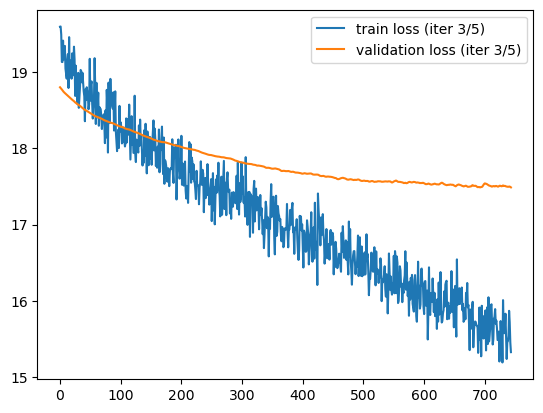

Surrogate vs Simulator y-space C2ST AUC after iteration 2: 0.7443500000000001
Surrogate vs Simulator y-space SWD AUC after iteration 2: 2.85150146484375
Epoch x Chunk: 0, Weighted Loss: 1.5751818939753948, Entropy loss: 1.5751818939753948, Wasser loss: 1.5531368255615234
Epoch x Chunk: 500, Weighted Loss: 0.41698154630501805, Entropy loss: 0.9372598254849693, Wasser loss: 0.13683171570301056
Epoch x Chunk: 1000, Weighted Loss: 0.31998755914202603, Entropy loss: 1.0296518355614337, Wasser loss: -0.062139350920915604
Training loss did not improve. Stopped training after 1042 epochs x chunks.
y c2st AUC on simulator: 0.6632
y c2st AUC on surrogate: 0.6463
Source c2st AUC: 0.884
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 10.269613128282712
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 4/5 training with 1000 samples
Epoch: 0, Train Loss: 21.117308616638184, Val Loss: 21.48114776611328
Validation loss did not improve f

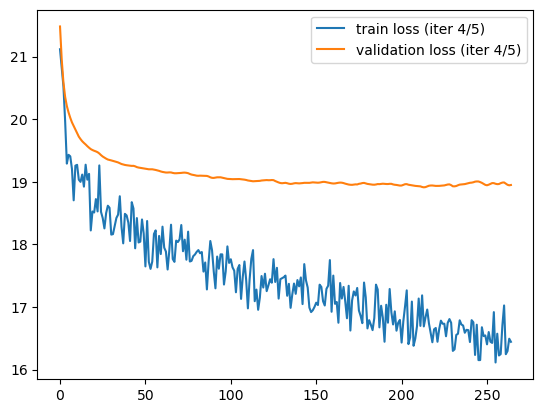

Surrogate vs Simulator y-space C2ST AUC after iteration 3: 0.7202999999999999
Surrogate vs Simulator y-space SWD AUC after iteration 3: 3.271775960922241
Epoch x Chunk: 0, Weighted Loss: 1.03310407389755, Entropy loss: 1.03310407389755, Wasser loss: 0.9099903106689453
Epoch x Chunk: 500, Weighted Loss: 0.3553150947435312, Entropy loss: 1.003812960878693, Wasser loss: 0.0061239455826580524
Epoch x Chunk: 1000, Weighted Loss: 0.49405569286611933, Entropy loss: 1.1057427416220422, Wasser loss: 0.16468575596809387
Epoch x Chunk: 1500, Weighted Loss: 0.3546856283792079, Entropy loss: 1.0834918344042785, Wasser loss: -0.03774847462773323
Training loss did not improve. Stopped training after 1529 epochs x chunks.
y c2st AUC on simulator: 0.642
y c2st AUC on surrogate: 0.6426499999999999
Source c2st AUC: 0.8698499999999999
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 10.169718357311632
--__----__----__----__----__----__----__----__----__----__--
IT

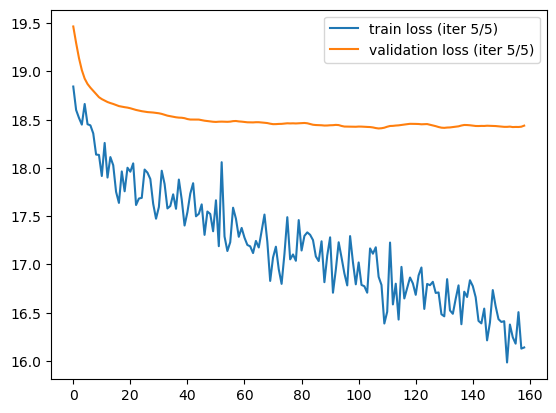

Surrogate vs Simulator y-space C2ST AUC after iteration 4: 0.70285
Surrogate vs Simulator y-space SWD AUC after iteration 4: 3.40297532081604
Epoch x Chunk: 0, Weighted Loss: 1.064424970928271, Entropy loss: 1.064424970928271, Wasser loss: 0.05355529487133026
Epoch x Chunk: 500, Weighted Loss: 0.3688508502898672, Entropy loss: 1.0442450362054396, Wasser loss: 0.005177067592740059
Epoch x Chunk: 1000, Weighted Loss: 0.3243565683659034, Entropy loss: 1.268426811752355, Wasser loss: -0.18398894369602203
Training loss did not improve. Stopped training after 1226 epochs x chunks.
y c2st AUC on simulator: 0.6265
y c2st AUC on surrogate: 0.62135
Source c2st AUC: 0.84975
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 10.070515174594808
--__----__----__----__----__----__----__----__----__----__--


In [72]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

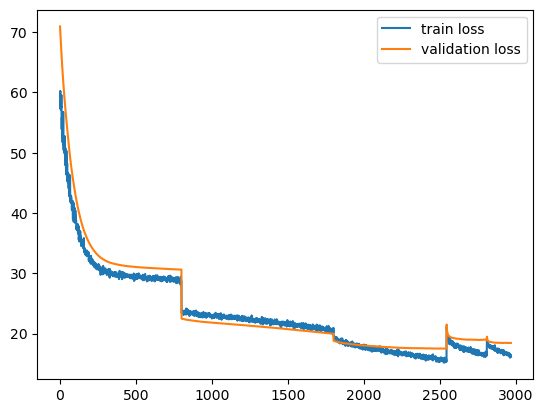

In [73]:
start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

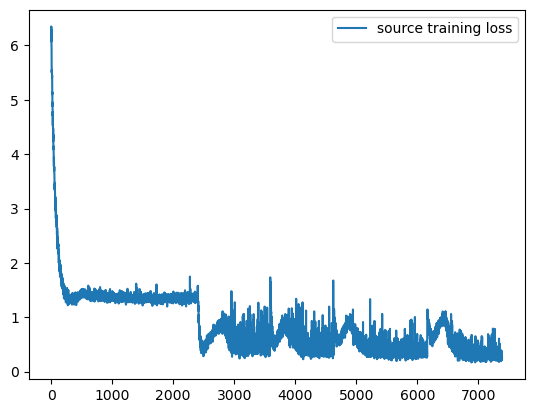

In [74]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

In [34]:
train_source_losses[-]

0.34522068516112214

ITERATION: 1/2 training with 1000 samples
Epoch: 0, Train Loss: 28925.091552734375, Val Loss: 46941.21875
Epoch: 500, Train Loss: 30.066238403320312, Val Loss: 32.0841064453125


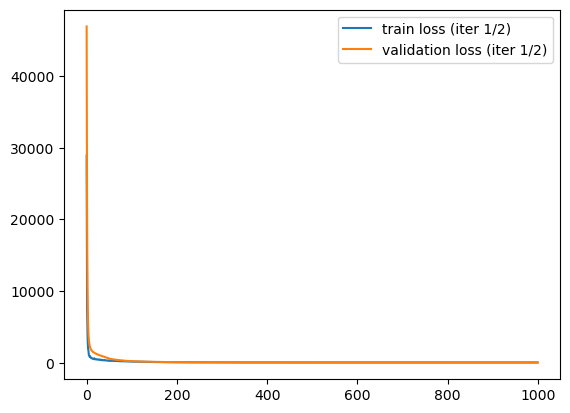

Surrogate vs Simulator y-space C2ST AUC Iteration: 0: 0.8012
Surrogate vs Simulator y-space SWD AUC Iteration: 0: 3.0513739585876465
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.2716542184352875
Epoch x Chunk: 500, Weighted Loss: 1.4733117444827215, Entropy loss: 1.01278010407436, Wasser loss: 1.670682430267334
Epoch x Chunk: 1000, Weighted Loss: 1.2837785081859456, Entropy loss: 2.258184527626926, Wasser loss: 0.8661758899688721
Epoch x Chunk: 1500, Weighted Loss: 1.399611949713245, Entropy loss: 2.749900111862069, Wasser loss: 0.8209169507026672
Epoch x Chunk: 2000, Weighted Loss: 1.3966293902186813, Entropy loss: 2.807879128072913, Wasser loss: 0.7918080687522888
Training loss did not improve. Stopped training after 2234 epochs x chunks.
y c2st AUC on simulator: 0.6266999999999999
y c2st AUC on surrogate: 0.5460999999999999
Source c2st AUC: 0.7116
--__----__----__----__----__----__----__----__----__----__--
ITERATION: 2/2 traini

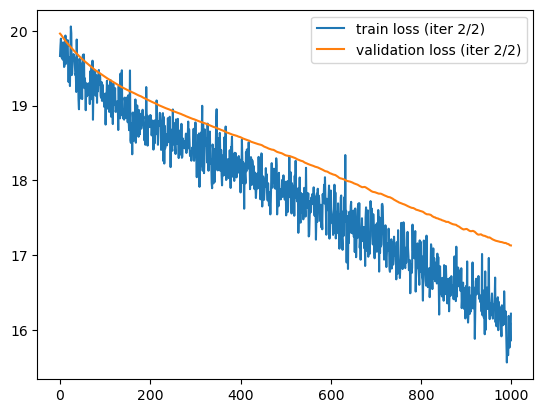

Surrogate vs Simulator y-space C2ST AUC Iteration: 1: 0.7741
Surrogate vs Simulator y-space SWD AUC Iteration: 1: 1.2752149105072021
Epoch x Chunk: 0, Weighted Loss: 2.7457769683427324, Entropy loss: 2.7457769683427324, Wasser loss: 0.4125820994377136
Epoch x Chunk: 500, Weighted Loss: 0.17224699390599124, Entropy loss: 0.8355975359662358, Wasser loss: -0.11204610764980316
Epoch x Chunk: 1000, Weighted Loss: 0.25666968860624123, Entropy loss: 0.9890854946936267, Wasser loss: -0.057222817093133926
Training loss did not improve. Stopped training after 1004 epochs x chunks.
y c2st AUC on simulator: 0.6560499999999999
y c2st AUC on surrogate: 0.59385
Source c2st AUC: 0.8823000000000001
--__----__----__----__----__----__----__----__----__----__--


In [16]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.append(train_loss); val_losses.append(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC Iteration: {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC Iteration: {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu(), ))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(
        c2st_scores(
            surro_estimated_pf.cpu(),
            gt_surrogate.cpu(),
        )
    )
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # samples of thetas
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")
    
    
    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

## note:
- after each iteration, we generate new data from the estimated source to fit the surrogate --> this means the train_data and val_data after each iteration are NOT SAME! So their should be a discontinuity in the loss curves below.

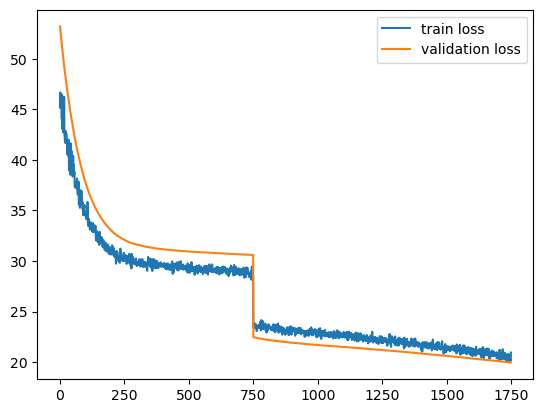

In [48]:
def flatten(xss):
    return [x for xs in xss for x in xs]
plt.plot(flatten(train_losses)[250:], label=f"train loss")
plt.plot(flatten(val_losses)[250:], label=f"validation loss")
plt.legend()
plt.show()

In [78]:
torch.cuda.empty_cache()

In [79]:
!nvidia-smi

Sat Nov 16 15:33:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DB:00.0 Off |                  N/A |
|  0%   33C    P2              34W / 250W |   4731MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--